# `almop` Library Setup

I'm developping a python library for helping me encapsulate analysis of causal structures in time series data. 
The library setup is as follows:
1. Initialize the logger and specify the logging level
2. Import local `almop` package path so that python will be able to call all needed functions
3. Import `almop` modules and all other libraries

## Step 1 - Logging

In [2]:
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(format='[%(levelname)s] %(asctime)s:\t %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Step 2 - System Path

In [3]:
import sys
import os

if f"{os.getcwd()}/../" not in ' '.join(sys.path):
    logging.info('Local module \'almop\' not found in system path. Appending...')
    sys.path.append(f"{os.getcwd()}/../")

[INFO] 2023-05-03 16:37:04,305:	 Local module 'almop' not found in system path. Appending...


## Step 3 - Import Libraries

In [4]:
#from almop import data as ald
from almop import data as ald
from almop import core as alc
import pandas as pd

## Parse Config

I'm using a configuration file that all notebooks can refer to. It contains useful parameters defining execution, such as the location on disk where the datasets should be persisted to.

**NOTE**: If you're running this for yourself, make sure to modify the config file appropriately. Everything else should then work smoothly.

In [5]:
config = alc.parse_config('config.toml')
config

{'dataset_persist_dir': '/wd4own/'}

## House Price Index

I'm loading HPI data from ***eurostat***. I'm calling a function in my custom `almop` package to download the data ***only if it's not cached*** in the directory specified in the config file.

In [6]:
hpi_raw = ald.get_hpi(config, ['PL', 'DE', 'IT', 'BE', 'SE'])

[INFO] 2023-05-03 16:37:08,455:	 Directory for persisting 'PRC_HPI_Q' not found. Creating '/wd4own/almop_datasets/eurostat/PRC_HPI_Q'...
[INFO] 2023-05-03 16:37:08,457:	 Pulling 'eurostat/PRC_HPI_Q' from the internet...
[INFO] 2023-05-03 16:37:08,920:	 Pulling 'eurostat/PRC_HPI_Q' complete.
[INFO] 2023-05-03 16:37:08,933:	 Persisted 'eurostat/PRC_HPI_Q' dataset.


I'll avoid overwriting `hpi_raw` by having a separate variable. That way if I'll need to re-run parts of the notebook I can always assume that `hpi_raw` contains a proper dataset in memory.

In [7]:
hpi = hpi_raw.copy()
hpi.head()

country,BE,DE,IT,PL,SE
2005-Q1,NaN,NaN,NaN,NaN,NaN
2005-Q2,2.2,-1.8,NaN,NaN,3.3
2005-Q3,3.6,2.1,NaN,NaN,3.9
2005-Q4,2.0,-2.8,NaN,NaN,2.6
2006-Q1,1.9,1.5,NaN,NaN,3.5


Let's plot the *House Price Index* for countries selected above to see how it evolves in time:

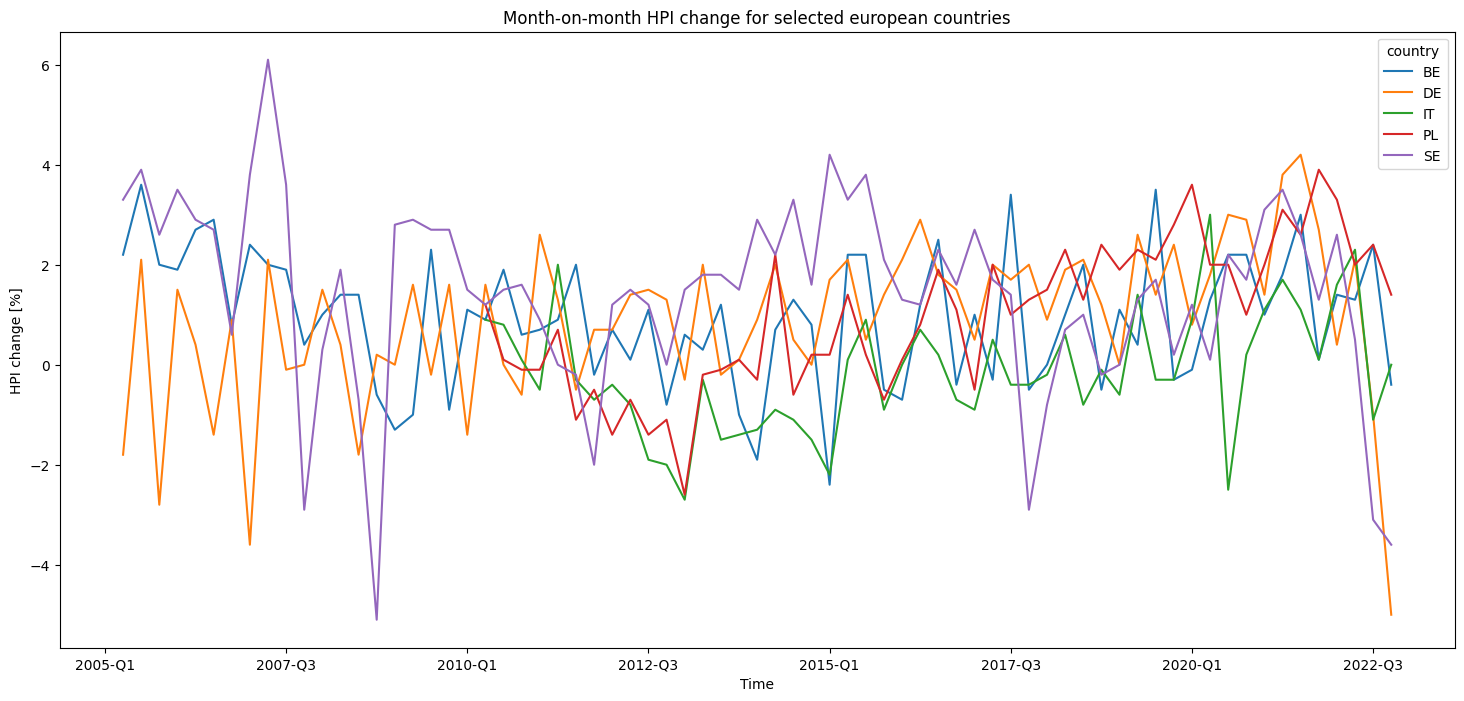

In [8]:
_ = hpi.plot(xlabel='Time', ylabel='HPI change [%]', title='Month-on-month HPI change for selected european countries', figsize=(18, 8), legend=True )

I see the following issues with HPI data loaded above:
1. It's not very granular - quarterly sampling
    * Low observation count per time series
2. Data for **Poland** is missing for a third of the whole time period
    * Will need to either drop data for other countries when not available for **Poland** or backfill for **Poland**

## Gross Domestic Product

One of the most famous metrics for a country is its ***GDP***. Let's visualize it in a similar way (using *eurostat* again):

In [12]:
gdp_raw = ald.get_gdp(config, ['PL', 'DE', 'IT', 'BE', 'SE'])

[INFO] 2023-05-03 16:37:58,381:	 Successfully loaded 'eurostat/NAMQ_10_GDP' from disk.


In [13]:
gdp = gdp_raw.copy()
gdp.head()

country,BE,DE,IT,PL,SE
1975-Q1,NaN,NaN,NaN,NaN,NaN
1975-Q2,NaN,NaN,NaN,NaN,NaN
1975-Q3,NaN,NaN,NaN,NaN,NaN
1975-Q4,NaN,NaN,NaN,NaN,NaN
1976-Q1,NaN,NaN,NaN,NaN,NaN


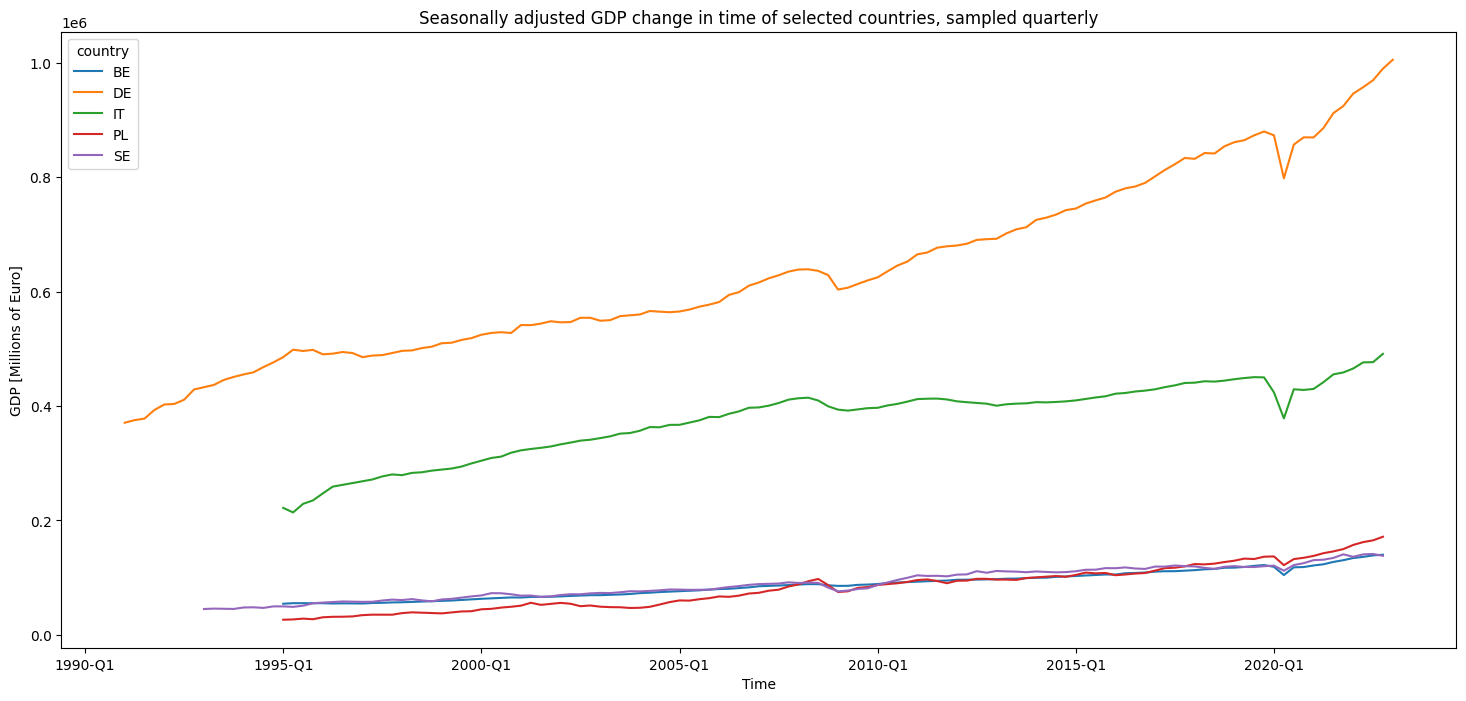

In [14]:
_ = gdp.plot(xlabel='Time', ylabel='GDP [Millions of Euro]', title='Seasonally adjusted GDP change in time of selected countries, sampled quarterly', figsize=(18, 8), legend=True )

Again, some problems with data can be identified:
* This time, starts of time series are even less systematic
* Series look heavily correlated (maybe even ***cointegrated***) which can lead to **false positive results** when looking for causality  

## Inflation - Total

In [19]:
infl_raw = ald.get_infl(config, ['PL', 'DE', 'IT', 'BE', 'SE', 'EA'])

[INFO] 2023-05-03 16:39:06,984:	 Successfully loaded 'eurostat/EI_CPHI_M' from disk.


In [20]:
infl = infl_raw.copy()
infl.head()

country,BE,DE,EA,IT,PL,SE
1996-01,NaN,NaN,NaN,NaN,NaN,NaN
1996-02,NaN,NaN,NaN,NaN,NaN,NaN
1996-03,NaN,NaN,NaN,NaN,NaN,NaN
1996-04,NaN,NaN,NaN,NaN,NaN,NaN
1996-05,NaN,NaN,NaN,NaN,NaN,NaN


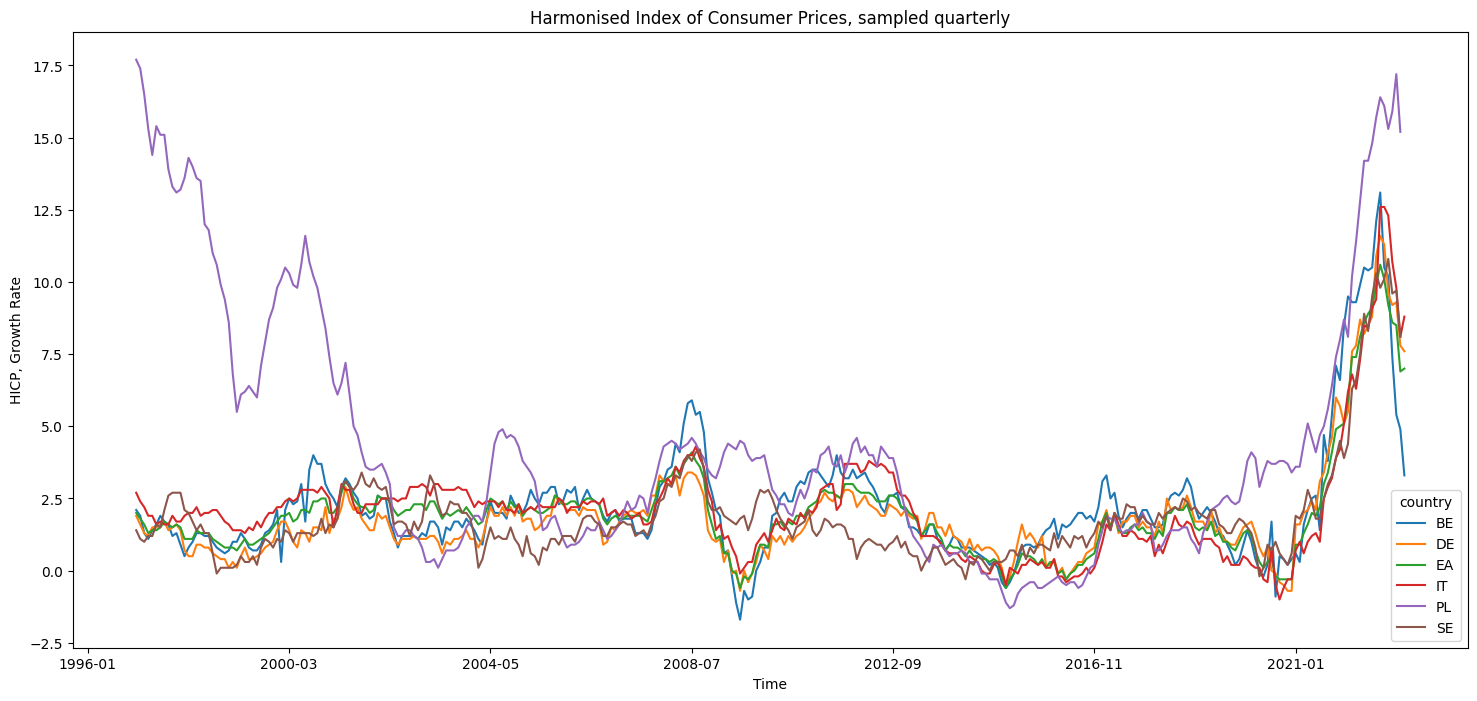

In [21]:
_ = infl.plot( xlabel='Time', ylabel='HICP, Growth Rate', title='Harmonised Index of Consumer Prices, sampled quarterly', figsize=(18, 8), legend=True )

## MRO

In [22]:
# Reading a local file on Main Refinancing Operations (MRO) rate:
mro = pd.read_csv( '/wd4own/ecb_mro.csv' )

In [27]:
mro.head()

,Obs. date,Obs. value
0,2023-03-22,3.50
1,2023-02-08,3.00
2,2022-12-21,2.50
3,2022-11-02,2.00
4,2022-09-14,1.25


In [28]:
mro = mro.set_index('Obs. date')

In [21]:
mro = mro.sort_values(by='Obs. date')

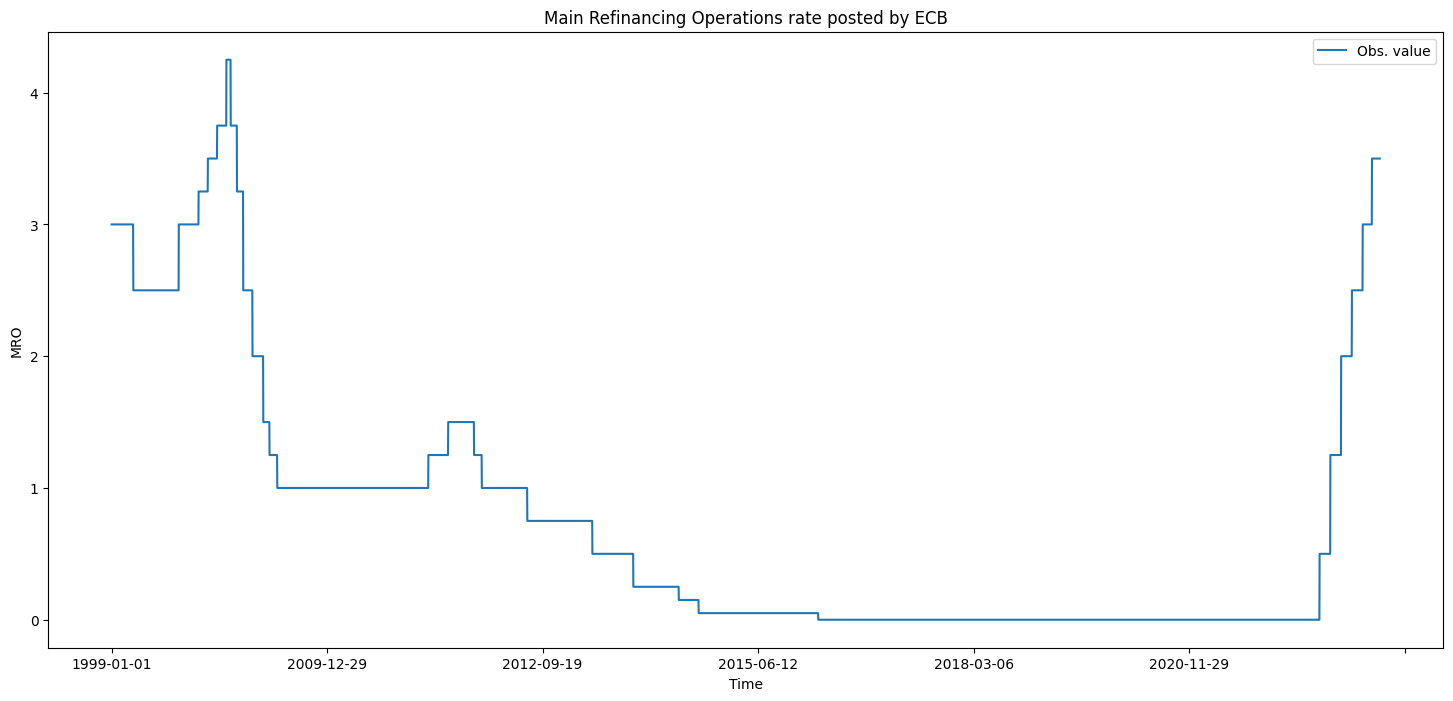

In [22]:
_ = mro.plot(xlabel='Time', ylabel='MRO', title='Main Refinancing Operations rate posted by ECB', figsize=(18, 8), legend=True )

### Plot MRO and Eurozone Inflation Together

In [23]:
infl_ea = pd.DataFrame( infl['EA'] )
infl_ea.head()

,EA
1996-01,NaN
1996-02,NaN
1996-03,NaN
1996-04,NaN
1996-05,NaN


In [24]:
mro.index = pd.to_datetime(mro.index, format = '%Y-%m-%d').strftime('%Y-%m')
mro.head()

,Obs. value
Obs. date,
1999-01,3.0
1999-01,3.0
1999-01,3.0
1999-01,3.0
1999-01,3.0


In [21]:
joined = mro.merge(infl_ea, how='left', left_on='Obs. date', right_on=infl_ea.index)
joined = joined.set_index('Obs. date')
joined.head()

,Obs. value,EA
Obs. date,,
1999-01,3.0,0.8
1999-01,3.0,0.8
1999-01,3.0,0.8
1999-01,3.0,0.8
1999-01,3.0,0.8


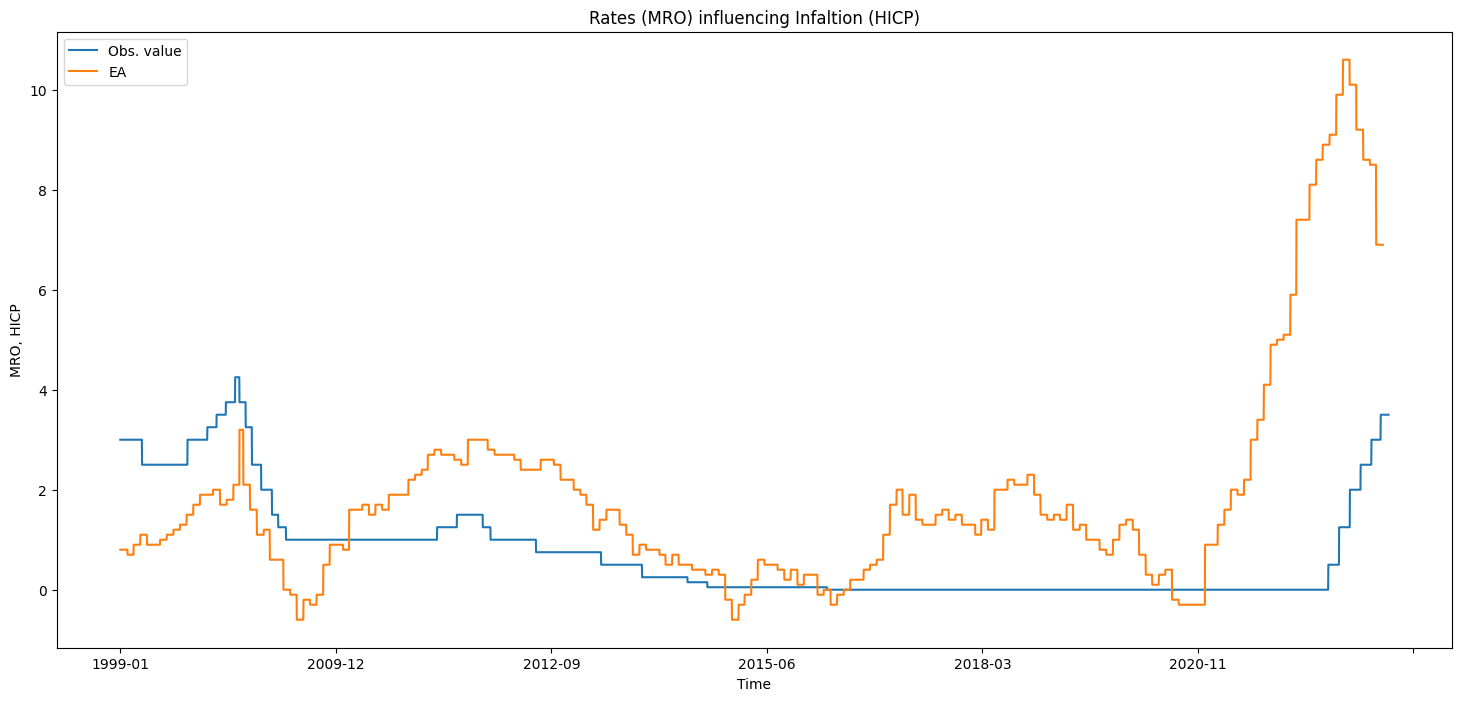

In [22]:
_ = joined.plot(xlabel='Time', ylabel='MRO, HICP', title='Rates (MRO) influencing Infaltion (HICP)', figsize=(18, 8), legend=True)

In [2]:
import cupy as cp
x = cp.arange(20000*30000).reshape(20000, 30000).astype('f')
x.sum(axis=1)


array([4.4998502e+08, 1.3499850e+09, 2.2499848e+09, ..., 1.7997748e+13,
       1.7998650e+13, 1.7999552e+13], dtype=float32)

In [3]:
del x

In [4]:
mempool = cp.get_default_memory_pool()
mempool.free_all_blocks()